In [168]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d, binned_statistic
from numba import njit
import h5py as h5

import astropy.units as u
from scipy.spatial import KDTree
from scipy.stats import gaussian_kde


In [5]:
import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [6]:
@njit
def rodrigues_formula(k, v, theta):
    N = v.shape[0]
    v_rot = np.zeros(np.shape(v))
    
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    
    for i in range(N):
        v_rot[i] = v[i] * ctheta + np.cross(k, v[i]) * stheta + k * (np.dot(k, v[i])) * (1-ctheta)
    
    return v_rot

In [7]:
GFM_SOLAR_METALLICITY = 0.0127

GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_HELIUM  =  (1.-GFM_SOLAR_ABUNDANCE_HYDROGEN -GFM_SOLAR_METALLICITY)
GFM_SOLAR_ABUNDANCE_CARBON  =  0.0024
GFM_SOLAR_ABUNDANCE_NITROGEN =  0.0007
GFM_SOLAR_ABUNDANCE_OXYGEN  =  0.0057
GFM_SOLAR_ABUNDANCE_NEON    =  0.0012
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_SILICON =  0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013
GFM_SOLAR_ABUNDANCE_OTHER  =   0

HUBBLE = 3.2407789e-18
SEC_PER_MEGAYEAR = 3.15576e13

In [8]:
def get_time(time, redshift=False, 
             Omega0=0.3089, 
             OmegaLambda=0.6911,
             HubbleParam=0.6774):
    HUBBLE = 3.2407789e-18
    SEC_PER_MEGAYEAR = 3.15576e13
    
    if redshift:
        a = 1./(1.+time)
    else:
        a = time
    
    fac = 2. / (3. * np.sqrt(OmegaLambda))
    ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))

    ans /= HUBBLE * HubbleParam
    ans /= SEC_PER_MEGAYEAR * 1000
    
    return ans

In [9]:
meta = {}
meta['snap_list'] = np.arange(100)
meta['header'] = []
meta['redshift'] = []
meta['scale_factor'] = []
meta['time'] = []
meta['time_lookback'] = []

t0 = get_time(1.)

for i in meta['snap_list']:
    header = arepo.Snapshot(TNGbase, i, onlyHeader=True)
    
    meta['header'].append(header)
    meta['redshift'].append(header.Redshift)
    meta['scale_factor'].append(header.Time)
    meta['time'].append(get_time(header.Time))
    meta['time_lookback'].append(t0 - get_time(header.Time))

meta['redshift'] = np.array(meta['redshift'])
meta['scale_factor'] = np.array(meta['scale_factor'])
meta['time'] = np.array(meta['time'])
meta['time_lookback'] = np.array(meta['time_lookback'])

In [10]:
def get_rot_pos_vel(snap, subhalo, ptype=4, rhalf_fac=2, phys=False):
    # get COM, COMV, and ang mom of stars
    COM = subhalo['SubhaloPos']
    pos = snap[4]['Coordinates'] - COM
    r = np.linalg.norm(pos, axis=1)
    
    rhalf = subhalo['SubhaloHalfmassRadType'][4]
    print(rhalf)

    in_rhalf = r < 2 * rhalf
    is_star = snap[4]['GFM_StellarFormationTime'] > 0
    is_star_in_rhalf = np.logical_and(is_star, in_rhalf)
    
    vel_in_rhalf = snap[4]['Velocities'][is_star_in_rhalf]
    mass_in_rhalf = snap[4]['Masses'][is_star_in_rhalf]
    COMV = np.average(vel_in_rhalf, axis=0, weights=mass_in_rhalf)
    print(COMV)
    
    vel = snap[4]['Velocities'] - COMV
    
    ang = np.cross(pos[is_star_in_rhalf], vel[is_star_in_rhalf])
    ang *= mass_in_rhalf.reshape(-1, 1)
    ang = np.sum(ang, axis=0)
    
    ang_mom = ang

    angmom_dir = ang_mom/np.linalg.norm(ang_mom)
    print(angmom_dir)
    theta = np.arccos(np.dot(angmom_dir, np.array([0, 0, 1])))
    k = np.cross(ang_mom, np.array([0, 0, 1.]))
    k /= np.linalg.norm(k)

    pos = snap[ptype]['Coordinates'] - COM
    vel = snap[ptype]['Velocities'] - COMV
    mass = snap[ptype]['Masses']
    
    pos_rot = rodrigues_formula(k, pos.astype(np.float64), theta)
    vel_rot = rodrigues_formula(k, vel.astype(np.float64), theta)
    
    # if phys:
    #     pos_rot *= meta['header'][].Time/meta['header'][].HubbleParam
    #     vel_rot *= np.sqrt(meta['header'][].Time)
    
    return pos_rot, vel_rot, mass

In [11]:
subID = 523889

subhalo = il.groupcat.loadSingle(TNGbase, 99, subhaloID=subID)

In [12]:
snap = {}
snap[4] = il.snapshot.loadSubhalo(TNGbase, 99, subID, 4)
snap[3] = il.snapshot.loadSubhalo(TNGbase, 99, subID, 3)

In [85]:
pos, vel, mass = get_rot_pos_vel(snap, subhalo, rhalf_fac=1)
pos *= meta['header'][99].Time/meta['header'][99].HubbleParam
vel *= np.sqrt(meta['header'][99].Time)
mass /= meta['header'][99].HubbleParam

3.4344184
[-198.0273  -127.60852  -84.05695]
[ 0.36309068 -0.72906581  0.58019669]


In [154]:
R = np.linalg.norm(pos[:,:2], axis=1)
sphi = pos[:,1]/R
cphi = pos[:,0]/R
vphi = -sphi*vel[:,0] + cphi*vel[:,1]
z = pos[:,2]

Lz = R * vphi
Lzsun = 8 * 220 * 1.2
in_SN = np.logical_and(np.abs(Lz/Lzsun-1) < 0.1, np.abs(pos[:,2] < 3))

# Rmin = 4
# Rmax = 16
# zmin = 0
# zmax = 3
# key_R = np.logical_and(R < Rmax, R > Rmin)
# key = np.logical_and(key_R, np.abs(z) < zmax)
# in_SN = np.logical_and(key, np.abs(z) > zmin)


is_star = snap[4]['GFM_StellarFormationTime'] > 0
is_star_in_SN = np.logical_and(is_star, in_SN)

Z = snap[4]['GFM_Metallicity'] / GFM_SOLAR_METALLICITY
logZ = np.log10(Z)

FeH = snap[4]['GFM_Metals'][:,8] / GFM_SOLAR_ABUNDANCE_IRON
logFeH = np.log10(FeH)

MgH = snap[4]['GFM_Metals'][:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
logMgH = np.log10(MgH)

MgFe = MgH/FeH
logMgFe = np.log10(MgFe)

In [87]:
def plot_map(fig, ax, logFeH, logMgFe, scalar=None, subsamp=None, tform=None, tform_min=0, tform_max=10,
             Rmin=4, Rmax=16, zmin=0, zmax=3, exclude=None, nres=50, sigma=1,
             logFeH_min=-1.1, logFeH_max=0.4, logMgFe_min=0.15, logMgFe_max=0.65,
             K=64, vmin=None, vmax=None, asymmetry=False, norm=0, cmap=None):
    
    if exclude is not None:
        key = np.logical_or(tform < exclude[0], tform > exclude[1])
    else:
        key = np.full(len(logFeH), True)
    
    data = np.vstack((logFeH[key], logMgFe[key])).T
    N = len(data)
    tree = KDTree(data)
        
    dlogFeH = (logFeH_max - logFeH_min)/nres
    dlogMgFe = (logMgFe_max - logMgFe_min)/nres
        
    logFeH_lin = np.linspace(logFeH_min + dlogFeH, logFeH_max-dlogFeH, nres)
    logMgFe_lin = np.linspace(logMgFe_min + dlogMgFe, logMgFe_max-dlogMgFe, nres)
    
    logFeH_grid, logMgFe_grid = np.meshgrid(logFeH_lin, logMgFe_lin)
    grid = np.vstack([logFeH_grid.ravel(), logMgFe_grid.ravel()]).T

    distances, indices = tree.query(grid, k=K)
    kth_distances = distances[:, -1]
    
    # Calculate the density: Inverse of the area of the circle surrounding the Kth neighbor
    density = K / (N * np.pi * kth_distances**2)
    density = np.reshape(density, logFeH_grid.shape).T
    
    downstairs = np.max(density, axis=1)
    
    # downstairs = np.sum(mbin, axis=1)
    # vmin = 0.01
    # vmax = 0.2
    
    if norm == 0:
        # norm = None
        # norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        # norm = mpl.colors.PowerNorm(gamma=0.5)
    
    downstairs[downstairs == 0.0] = 1e-20
    density = (density.T / downstairs).T
    density[density < norm.vmin] = norm.vmin
        
    extent = [logFeH_min, logFeH_max, logMgFe_min, logMgFe_max]
    
    im = ax.imshow(density.T, origin='lower',
               extent=extent,
               norm=norm, cmap=cmap)

    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_aspect('auto')
    
    return im

[Text(0, 0.5, '[Mg/Fe]')]

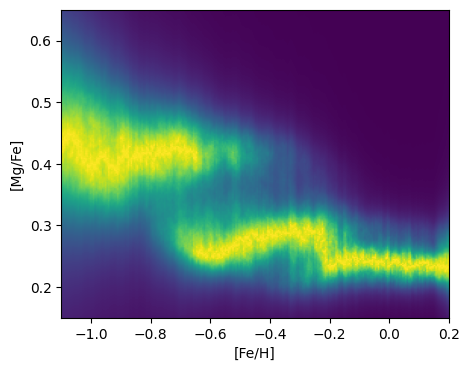

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

logvmin = -1
logvmax = 1.8
im = plot_map(fig, ax, logFeH[is_star_in_SN], logMgFe[is_star_in_SN], nres=256,
              logFeH_max=0.2, K=256, norm=mpl.colors.Normalize(vmin=0, vmax=1.0))

# fig.colorbar(im, ax=ax)

ax.set(xlabel='[Fe/H]')
ax.set(ylabel='[Mg/Fe]')

[Text(0.5, 1.0, 'TNG50 galaxy 523889')]

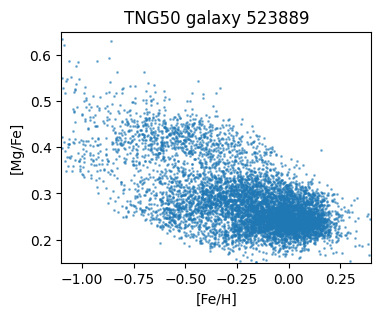

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

logFeH_min=-1.1
logFeH_max=0.4
logMgFe_min=0.15
logMgFe_max=0.65

subsamp = 8000

tform = get_time(snap[4]['GFM_StellarFormationTime'])
is_old = tform < 100
key = np.logical_and(is_star_in_SN, is_old)
key = np.where(key)[0]
key = np.random.choice(key, subsamp, replace=False)
            
ax.scatter(logFeH[key], logMgFe[key], s=1, alpha=0.5)
ax.set(xlim=(logFeH_min, logFeH_max), ylim=(logMgFe_min, logMgFe_max))
ax.set(xlabel='[Fe/H]', ylabel='[Mg/Fe]')
ax.set(title='TNG50 galaxy 523889')

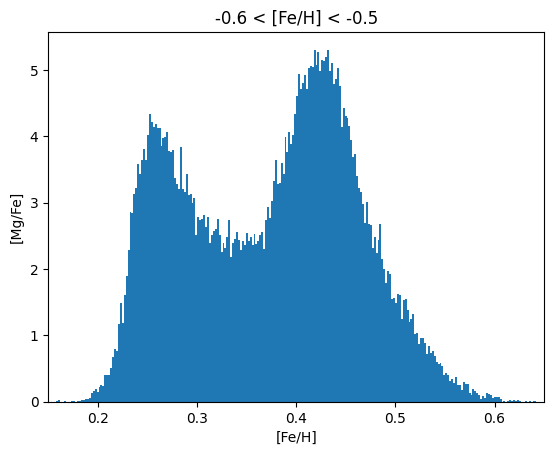

In [164]:
# in_plot_FeH = np.logical_and(logFeH > -1.1, logFeH < 0.2)
in_plot_FeH = np.logical_and(logFeH > -0.6, logFeH < -0.5)
# in_plot_FeH = np.logical_and(logFeH > -0.3, logFeH < -0.2)
plt.title('-0.6 < [Fe/H] < -0.5')

bins=np.linspace(0.15, 0.65, 256+1)

is_star_in_SN_in_plot = np.logical_and(is_star, in_plot_FeH)

plt.hist(logMgFe[is_star_in_SN_in_plot], bins=bins, weights=mass[is_star_in_SN_in_plot], density=True);
plt.xlim(0.15, 0.65)
plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')
plt.axvline(5.5, c='k', ls='dashed')

0.057356044865502845


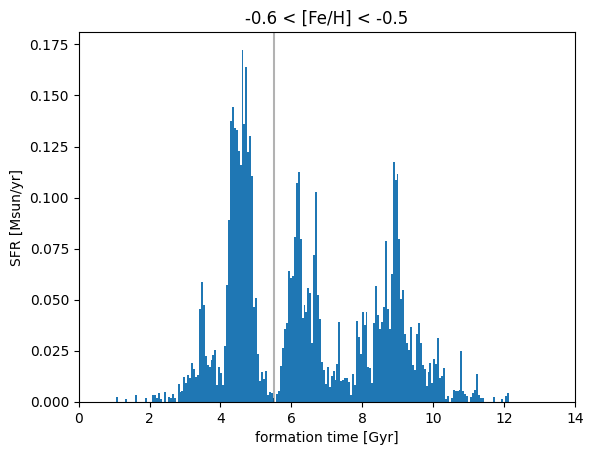

In [119]:
tform = get_time(snap[4]['GFM_StellarFormationTime'])

# in_plot_FeH = np.logical_and(logFeH > -1.1, logFeH < 0.2)
in_plot_FeH = np.logical_and(logFeH > -0.6, logFeH < -0.5)
plt.title('-0.6 < [Fe/H] < -0.5')

in_plot_MgFe = np.logical_and(logMgFe > 0.15, logMgFe < 0.65)
in_plot = np.logical_and(in_plot_FeH, in_plot_MgFe)
print(np.sum(in_plot)/len(logFeH))
is_star_in_SN_in_plot = np.logical_and(is_star_in_SN, in_plot)

mass = snap[4]['GFM_InitialMass'] / meta['header'][99].HubbleParam

bins=np.linspace(0, 14, 256+1)
dt = (bins[-1]-bins[0])/(len(bins)-1)

sfr = (1E10 * mass) / (1E9 * dt)

plt.hist(tform[is_star_in_SN_in_plot], bins=bins, weights=sfr[is_star_in_SN_in_plot]);
plt.xlim(0, 14)
plt.xlabel('formation time [Gyr]')
plt.ylabel('SFR [Msun/yr]')
plt.axvline(5.5, c='k', alpha=0.3)

0.057356044865502845


Text(8, 0.075, 'with 500 Myr age errors')

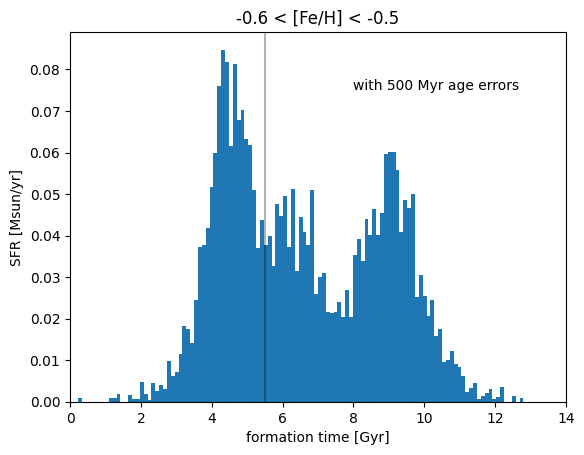

In [160]:
tform = get_time(snap[4]['GFM_StellarFormationTime'])
tform = np.random.normal(tform, 0.5)

# in_plot_FeH = np.logical_and(logFeH > -1.1, logFeH < 0.2)
in_plot_FeH = np.logical_and(logFeH > -0.6, logFeH < -0.5)
plt.title('-0.6 < [Fe/H] < -0.5')

in_plot_MgFe = np.logical_and(logMgFe > 0.15, logMgFe < 0.65)
in_plot = np.logical_and(in_plot_FeH, in_plot_MgFe)
print(np.sum(in_plot)/len(logFeH))
is_star_in_SN_in_plot = np.logical_and(is_star_in_SN, in_plot)

mass = snap[4]['GFM_InitialMass'] / meta['header'][99].HubbleParam

bins=np.linspace(0, 14, 128+1)
dt = (bins[-1]-bins[0])/(len(bins)-1)

sfr = (1E10 * mass) / (1E9 * dt)

plt.hist(tform[is_star_in_SN_in_plot], bins=bins, weights=sfr[is_star_in_SN_in_plot]);
plt.xlim(0, 14)
plt.xlabel('formation time [Gyr]')
plt.ylabel('SFR [Msun/yr]')
plt.axvline(5.5, c='k', alpha=0.3)
plt.text(8, 0.075, 'with 500 Myr age errors')

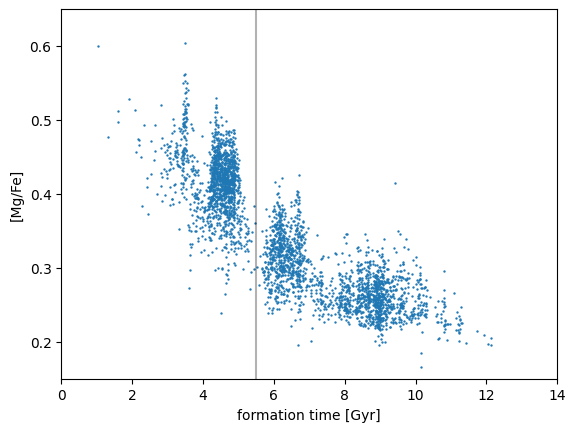

In [118]:
key = np.logical_and(logFeH > -0.6, logFeH < -0.5)
key = np.logical_and(key, is_star_in_SN)

plt.scatter(tform[key], logMgFe[key], s=0.5)
plt.xlim(0, 14)
plt.ylim(0.15, 0.65)
plt.xlabel('formation time [Gyr]')
plt.ylabel('[Mg/Fe]')
plt.axvline(5.5, c='k', alpha=0.3)

In [187]:
def make_plot(save=True):
    logFeH_min=-1.1
    logFeH_max=0.6
    logMgFe_min=0.1
    logMgFe_max=0.65

    dlogFeH = 0.1

    fig, axs = plt.subplots(4, 1, figsize=(4, 12))

    key = np.where(is_star_in_SN)[0]
    key = np.random.choice(key, subsamp, replace=False)
                        
    axs[0].scatter(logFeH[key], logMgFe[key], s=1, alpha=0.5, c='k')
    axs[0].set(xlim=(logFeH_min, logFeH_max), ylim=(logMgFe_min, logMgFe_max))
    
    axs[0].set_title('TNG 523889')
    axs[0].set(xlabel='[Fe/H]', ylabel='[Mg/Fe]')

    # for logFeH0 in [-0.75, -0.5, -0.25, 0, 0.25]:
    offset = -0.3
    # for i,logFeH0 in enumerate([-0.5, -0.25, 0, 0.25]):
    for i,logFeH0 in enumerate([-0.75, -0.5, -0.25, 0]):
        key = np.logical_and(logFeH > logFeH0 - dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
        key = np.logical_and(key, is_star_in_SN)
    
        kernel = gaussian_kde(logMgFe[key])
        xlist = np.linspace(-3, 3, 1000+1)
        val = kernel(xlist)
            
        # l = axs[1].plot(xlist+offset, val)
        _, _, l = axs[1].hist(logMgFe[key]+offset, bins=np.linspace(logMgFe_min-0.2, logMgFe_max+0.4, 100+1))
        # print(l)
        c = l[0].get_facecolor()
        axs[0].axvline(logFeH0, c=c)
    
        offset += 0.3
    
        # SFH
        # tform = gal.sn.part4.GFM_StellarFormationTime
        tform = get_time(snap[4]['GFM_StellarFormationTime'])
        # kernel = gaussian_kde(tform[key], bw_method='silverman')
        # xlist = np.linspace(0, 8, 1000+1)
        # val = kernel(xlist)
    
        # axs[2].plot(xlist, val, c=c)
        # if i==0 or i==3:
        if False:
            alpha=0.8
            lw = 1
        else:
            alpha=1
            lw = 1.45
        h = axs[2].hist(tform[key], bins=np.linspace(0, 14, 64+1), histtype='step', alpha=alpha, lw=lw)
    
        # alpha vs tform
        key = np.where(key)[0]
        # key = np.random.choice(key, int(0.1*len(key) + 0.5), replace=False)
        # key = np.random.choice(key, 2000, replace=False)
        axs[3].scatter(tform[key], logMgFe[key]+offset, alpha=0.3, color=c, s=0.1)

    axs[1].set(xlim=(logMgFe_min-0.2, logMgFe_max+0.4), ylim=(0, None))
    axs[2].set(xlim=(0, 14), ylim=(0, None))

    axs[1].set(xlabel='[Mg/Fe] + offset', ylabel='count')
    axs[2].set(xlabel='formation time [Gyr]', ylabel='count')
    axs[3].set(xlabel='formation time [Gyr]', ylabel='[Mg/Fe] + offset')

    fig.tight_layout()
    
    if save:
        fig.savefig('../../note/fig/TNG_523889.png')
        plt.close()

In [188]:
make_plot()

Text(0, 0.5, '[Fe/H]')

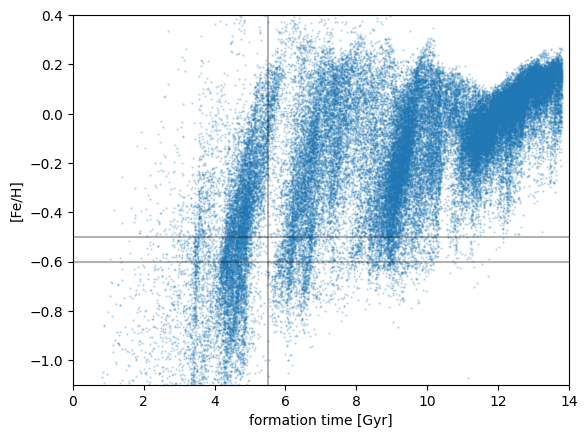

In [131]:
key = np.logical_and(logFeH > -0.6, logFeH < -0.5)
key = np.logical_and(key, is_star_in_SN)

plt.scatter(tform[is_star_in_SN], logFeH[is_star_in_SN], s=0.3, alpha=0.3)
plt.ylim(-2, None)
plt.axvline(5.5, c='k', alpha=0.3)
plt.axhline(-0.6, c='k', alpha=0.3)
plt.axhline(-0.5, c='k', alpha=0.3)
plt.xlim(0, 14)
plt.ylim(-1.1, 0.4)
plt.xlabel('formation time [Gyr]')
plt.ylabel('[Fe/H]')

0.9908591942508568


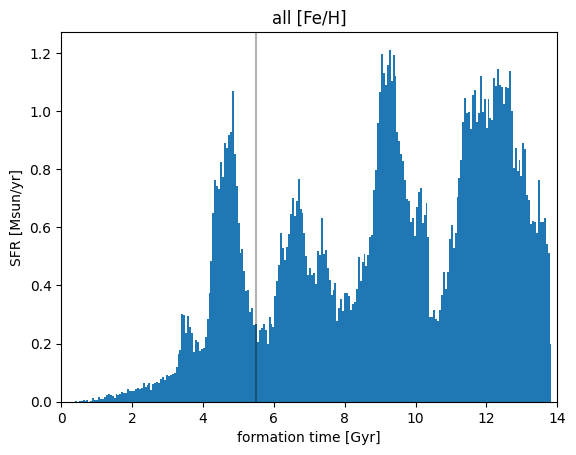

In [127]:
tform = get_time(snap[4]['GFM_StellarFormationTime'])

# in_plot_FeH = np.logical_and(logFeH > -1.1, logFeH < 0.2)
in_plot_FeH = np.logical_and(logFeH > -1e99, logFeH < 1e99)
plt.title('all [Fe/H]')

in_plot_MgFe = np.logical_and(logMgFe > 0.15, logMgFe < 0.65)
in_plot = np.logical_and(in_plot_FeH, in_plot_MgFe)
print(np.sum(in_plot)/len(logFeH))
is_star_in_SN_in_plot = np.logical_and(is_star_in_SN, in_plot)

mass = snap[4]['GFM_InitialMass'] / meta['header'][99].HubbleParam

bins=np.linspace(0, 14, 256+1)
dt = (bins[-1]-bins[0])/(len(bins)-1)

sfr = (1E10 * mass) / (1E9 * dt)

plt.hist(tform[is_star_in_SN_in_plot], bins=bins, weights=sfr[is_star_in_SN_in_plot]);
plt.xlim(0, 14)
plt.xlabel('formation time [Gyr]')
plt.ylabel('SFR [Msun/yr]')
plt.axvline(5.5, c='k', alpha=0.3)